# Neural Prophet Model

### Installing required libraries

In order to install the required libraries, you can use the following command in the terminal:

```bash
pip install -r requirements.txt
```

### Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
from neuralprophet import NeuralProphet
import matplotlib.pyplot as plt
%matplotlib inline

### Load data as pandas dataframe

The data we have refers to a single brand (`banbaloo`) and a single SKU (`5Y-8TNB-GV76`)

In [2]:
banbaloo = pd.read_csv("banbaloo_de_sku.csv")
banbaloo["sellerboard_date"] = pd.to_datetime(banbaloo["sellerboard_date"])
banbaloo.sort_values(by="sellerboard_date", inplace=True)

In [3]:
banbaloo["seller_sku"].unique()

array(['5Y-8TNB-GV76'], dtype=object)

In [4]:
banbaloo.tail()

,seller_name,seller_sku,daily_sales_sku,sellerboard_date
811,banbaloo,5Y-8TNB-GV76,504.15,2021-12-18
812,banbaloo,5Y-8TNB-GV76,638.58,2021-12-19
813,banbaloo,5Y-8TNB-GV76,739.38,2021-12-20
814,banbaloo,5Y-8TNB-GV76,504.14,2021-12-21
815,banbaloo,5Y-8TNB-GV76,134.44,2021-12-22


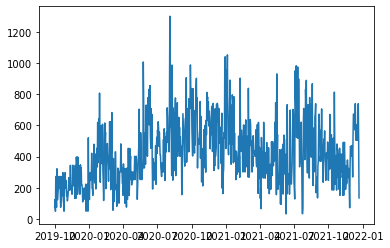

In [5]:
plt.plot(banbaloo["sellerboard_date"], banbaloo["daily_sales_sku"])

### Data preprocessing

In order to use `Neural Prophet` we need to transform the data into a format that it can understand:
* `ds`: the date of the observation
* `y`: the value of the observation

In [6]:
data = banbaloo.rename(columns={
    "sellerboard_date": "ds",
    "daily_sales_sku": "y"
})[["ds", "y"]].fillna(0)

data.head()

,ds,y
0,2019-09-09,0.00
1,2019-09-30,74.25
2,2019-10-01,123.68
3,2019-10-02,49.50
4,2019-10-03,272.19


### Using NeuralProphet

It's usage is very similar to the `Prophet` library, but in this case `NeuralProphet` adds new components to the prediction process:
* Gradient Descent for optimisation via using PyTorch as the backend.
* Modelling autocorrelation of time series using AR-Net
* Modelling lagged regressors using a sepearate Feed-Forward Neural Network.
* Configurable non-linear deep layers of the FFNNs.
* Tuneable to specific forecast horizons (greater than 1).
* Custom losses and metrics.

[NeuralProphet docs](https://neuralprophet.com/html/contents.html)


In [7]:
# initialize the model
m = NeuralProphet(
    n_changepoints=100,
    trend_reg=2, 
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
)

# separate the training and test data (80-20 split)
df_train, df_test = m.split_df(data, valid_p=0.2, freq="D")

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.755% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


In [8]:
print(df_train["ds"].apply(["min", "max"]))
print(df_test["ds"].apply(["min", "max"]))

min   2019-09-09
max   2021-07-12
Name: ds, dtype: datetime64[ns]
min   2021-07-13
max   2021-12-22
Name: ds, dtype: datetime64[ns]


In [9]:
# train the model
# using df_test as validation data
metrics = m.fit(df_train, validation_df=df_test, freq="D")

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.694% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 150


  0%|          | 0/241 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.91E+00, min: 3.98E-01


  0%|          | 0/241 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.94E+01, min: 2.18E-01


  0%|          | 0/241 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.15E+01, min: 5.16E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.26E+01
Epoch[150/150]: 100%|█| 150/150 [00:08<00:00, 16.70it/s, SmoothL1Loss=0.0216, MA


MAE (median)	and MSE/RMSE (mean): how far on average the predictions were from the true values.
SmoothL1Loss, RegLoss = 

In [10]:
# see results at the last training epoch
metrics.tail()

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
145,0.041892,173.047190,216.825982,0.022728,0.246143,496.783508,550.067871
146,0.033309,153.893421,194.439630,0.021681,0.209210,458.248474,506.048065
147,0.023911,132.102131,167.005100,0.021063,0.071833,240.529663,295.460266
148,0.022111,126.754151,161.518851,0.020913,0.142097,363.535858,415.736298
149,0.021614,125.234301,159.582523,0.020833,0.117172,323.362885,377.378540


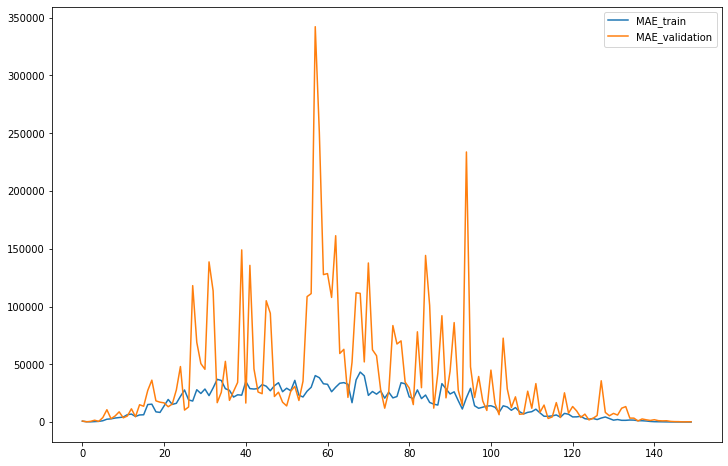

In [11]:
# learning curves for training and validation as a function of epochs
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(metrics.index, metrics["MAE"], label="MAE_train")
ax.plot(metrics.index, metrics["MAE_val"], label="MAE_validation")
ax.legend()

In [12]:
# tune the model
m = NeuralProphet(
    n_changepoints=300, # number of changepoints in terms of trend
    n_lags=28, # take into account the last N days as autoregressive features
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    n_forecasts=7, # forecast N days ahead
    learning_rate=0.1, # learning rate
    batch_size=28, # size of each mini-batch
    epochs=100, # number of epochs
    impute_missing=True, # impute missing values with linear interpolation
)

# separate the training and test data (80-20 split)
df_train, df_test = m.split_df(data, valid_p=0.2, freq="D")

# train the model
metrics = m.fit(df_train, validation_df=df_test, freq="D")

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.755% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.forecaster.__handle_missing_data) - 20 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - 20 NaN values in column y were auto-imputed.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.851% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
Epoch[100/100]: 100%|█| 100/100 [00:05<00:00, 19.18it/s, SmoothL1Loss=0.0172, MA


In [13]:
# see results at the last training epoch
metrics.tail()

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
95,0.017279,111.897982,143.889086,0.0,0.064094,242.402847,277.807892
96,0.017246,111.964788,143.604772,0.0,0.064443,243.232880,278.563660
97,0.017226,111.773460,143.564442,0.0,0.063660,241.615814,276.867157
98,0.017209,111.660064,143.533557,0.0,0.063680,241.658356,276.910217
99,0.017204,111.645011,143.513182,0.0,0.063642,241.581894,276.827972


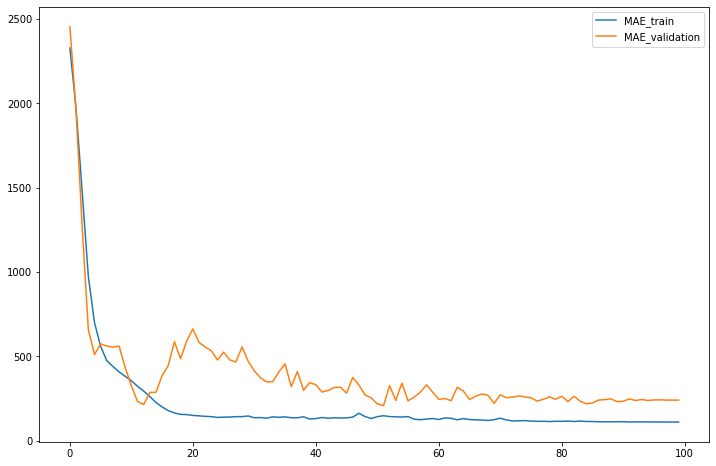

In [14]:
# learning curves for training and validation as a function of epochs
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(metrics.index, metrics["MAE"], label="MAE_train")
ax.plot(metrics.index, metrics["MAE_val"], label="MAE_validation")
ax.legend()

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.755% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.757% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.forecaster.__handle_missing_data) - 20 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - 20 NaN values in column y were auto-imputed.


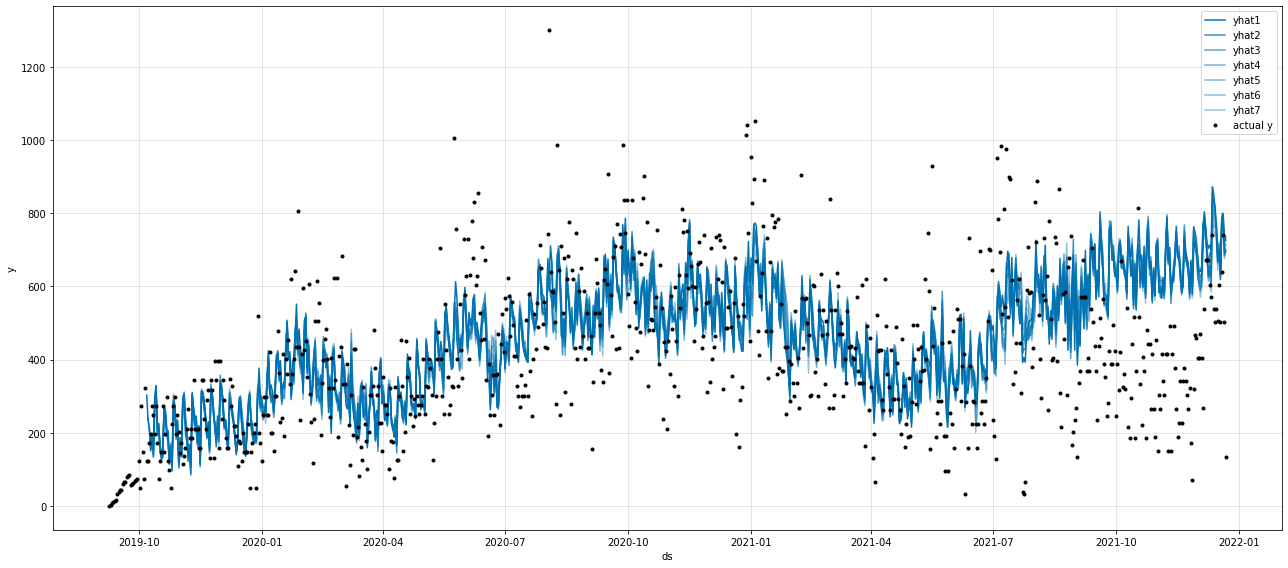

In [15]:
forecast = m.predict(data)
fig = m.plot(forecast, figsize=(18,8))

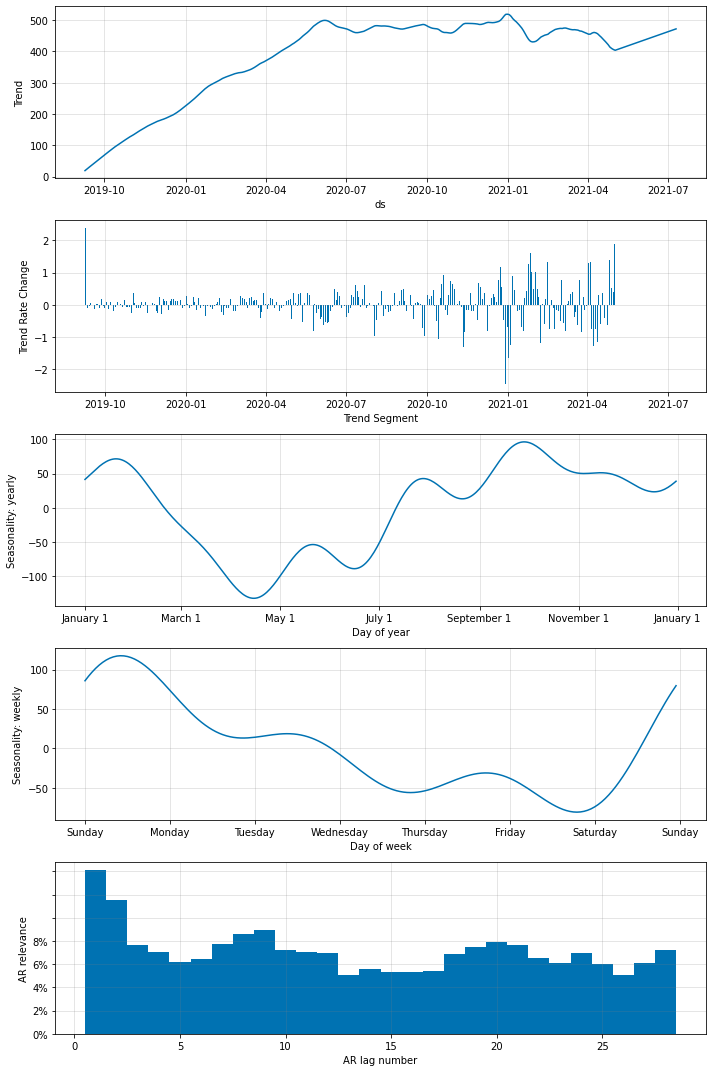

In [16]:
# components of the prediction
param = m.plot_parameters()

In [17]:
forecast

,ds,y,yhat1,residual1,yhat2,residual2,yhat3,residual3,yhat4,residual4,...,ar1,ar2,ar3,ar4,ar5,ar6,ar7,trend,season_yearly,season_weekly
0,2019-09-09,0.000000,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,2019-09-10,3.535714,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,2019-09-11,7.071429,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,2019-09-12,10.607143,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,2019-09-13,14.142857,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831,2021-12-18,504.150000,630.944336,126.794336,619.14032,114.99032,619.409851,115.259851,630.748657,126.598657,...,50.2323,38.428284,38.697792,50.036625,61.693214,74.954025,57.731365,631.580261,23.358862,-74.227066
832,2021-12-19,638.580000,784.554443,145.974443,774.731995,136.151995,757.236023,118.656023,768.163574,129.583574,...,42.59375,32.77132,15.275338,26.202888,29.59333,49.892612,57.03072,632.570923,23.54056,85.849213
833,2021-12-20,739.380000,800.267517,60.887517,776.002991,36.622991,767.270203,27.890203,767.874817,28.494817,...,69.121819,44.857269,36.124466,36.729141,38.235798,50.570183,62.961437,633.561523,23.900822,73.683342
834,2021-12-21,504.140000,737.202209,233.062209,713.467712,209.327712,695.03949,190.89949,684.860107,180.720107,...,64.043816,40.309322,21.88105,11.701684,3.190971,13.380539,18.299446,634.552185,24.440937,14.165266


   # SARIMAX Model
  

In [18]:
import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings('ignore')

In [19]:
data

,ds,y
0,2019-09-09,0.00
1,2019-09-30,74.25
2,2019-10-01,123.68
3,2019-10-02,49.50
4,2019-10-03,272.19
...,...,...
811,2021-12-18,504.15
812,2021-12-19,638.58
813,2021-12-20,739.38
814,2021-12-21,504.14


In [20]:
data=data.drop([0])

In [21]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [22]:
data.set_index('ds', inplace=True)

In [23]:
from statsmodels.tsa.stattools import adfuller
adfuller(data, autolag='AIC')

(-4.1621410620549115,
 0.0007631715740082707,
 12,
 802,
 {'1%': -3.4385299921076995,
  '5%': -2.8651505256266865,
  '10%': -2.568692571687987},
 10309.641306728943)

In [24]:
data = data['y']
data.head(10)

ds
2019-09-30     74.25
2019-10-01    123.68
2019-10-02     49.50
2019-10-03    272.19
2019-10-04    148.50
2019-10-05     74.20
2019-10-06    321.64
2019-10-07    123.75
2019-10-08    123.72
2019-10-09    173.17
Name: y, dtype: float64

<AxesSubplot:xlabel='ds'>

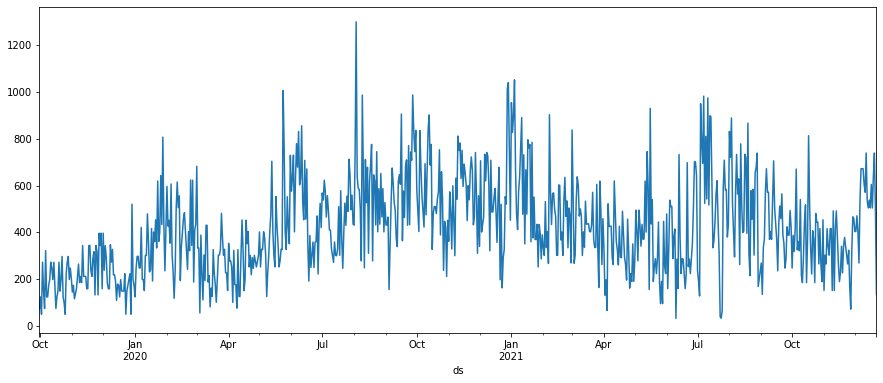

In [25]:
data.plot()

In [26]:
data.resample('D').mean()

ds
2019-09-30     74.25
2019-10-01    123.68
2019-10-02     49.50
2019-10-03    272.19
2019-10-04    148.50
               ...  
2021-12-18    504.15
2021-12-19    638.58
2021-12-20    739.38
2021-12-21    504.14
2021-12-22    134.44
Freq: D, Name: y, Length: 815, dtype: float64

In [27]:
from scipy import interpolate

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data)

In [29]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

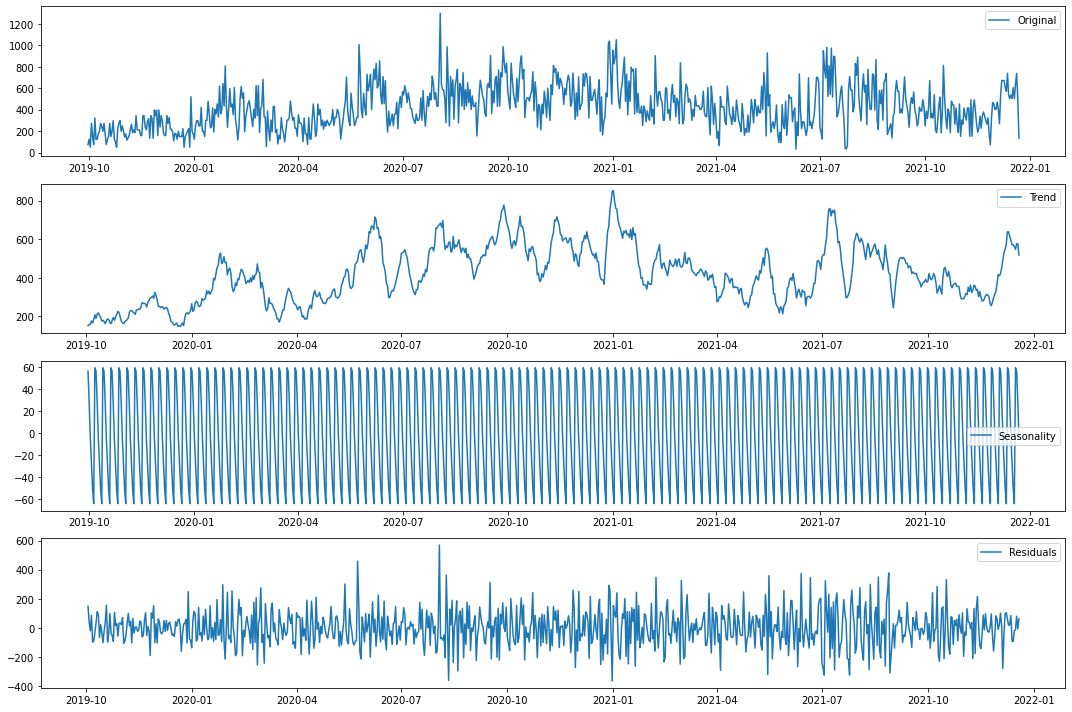

In [30]:
plt.figure(figsize=(15,10))
plt.subplot(411)
plt.plot(data, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

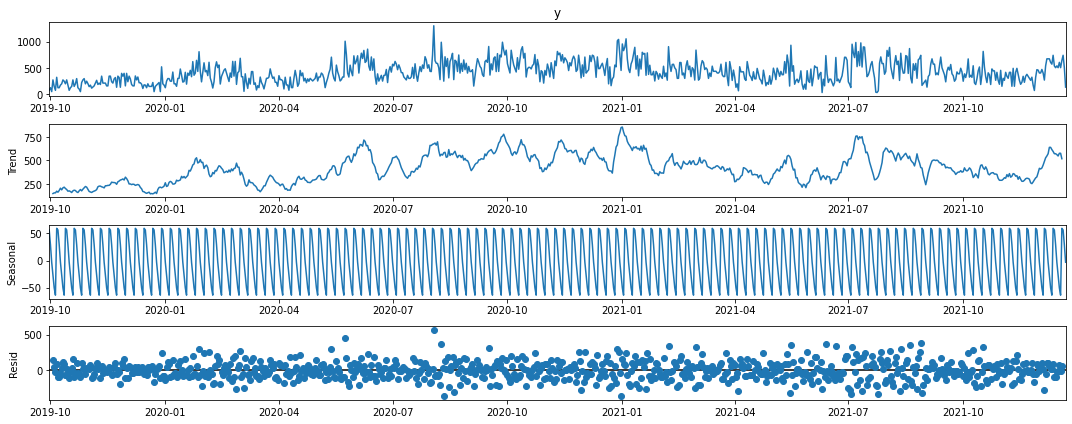

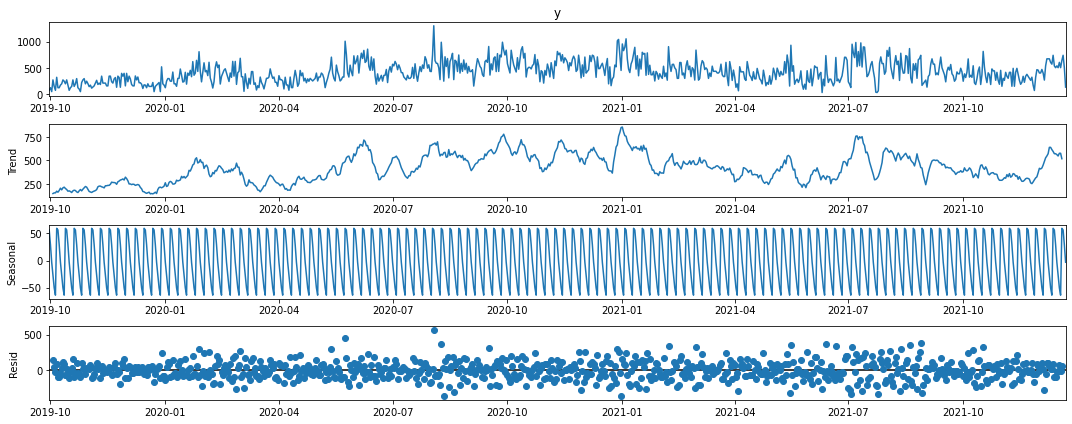

In [31]:
decomposition.plot()

## Checking for stationarity

In [32]:
def test_stationarity(timeseries):
    
    # Determing rolling statistics
    # rolmean = pd.rolling_mean(timeseries, window=12)
    # rolstd = pd.rolling_std(timeseries, window=12)
    
    rolstd = timeseries.rolling(12).std()    
    rolmean = timeseries.rolling(12).mean()


    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print(dfoutput)

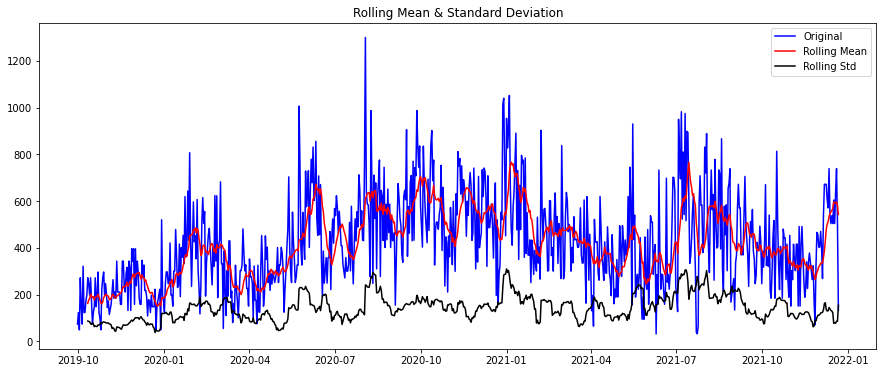

Results of Dickey-Fuller Test:
Test Statistic                  -4.162141
p-value                          0.000763
#Lags Used                      12.000000
Number of Observations Used    802.000000
Critical Value (1%)             -3.438530
Critical Value (5%)             -2.865151
Critical Value (10%)            -2.568693
dtype: float64


In [33]:
test_stationarity(data)

## Checking tendency


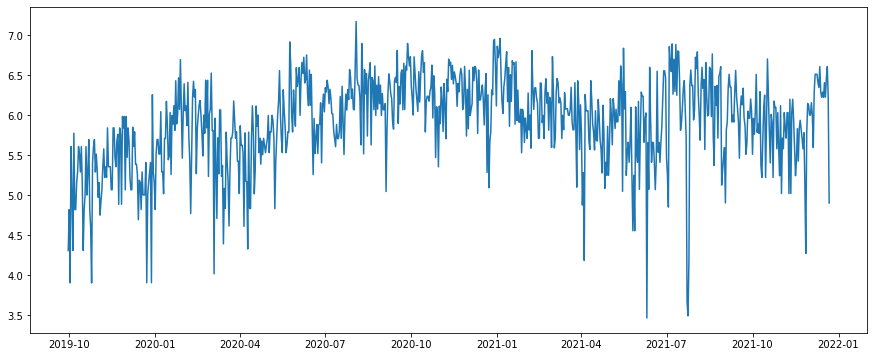

In [34]:
data_log = np.log(data)
plt.plot(data_log)

In [35]:
data_log

ds
2019-09-30    4.307438
2019-10-01    4.817698
2019-10-02    3.901973
2019-10-03    5.606500
2019-10-04    5.000585
                ...   
2021-12-18    6.222874
2021-12-19    6.459247
2021-12-20    6.605812
2021-12-21    6.222854
2021-12-22    4.901118
Name: y, Length: 815, dtype: float64

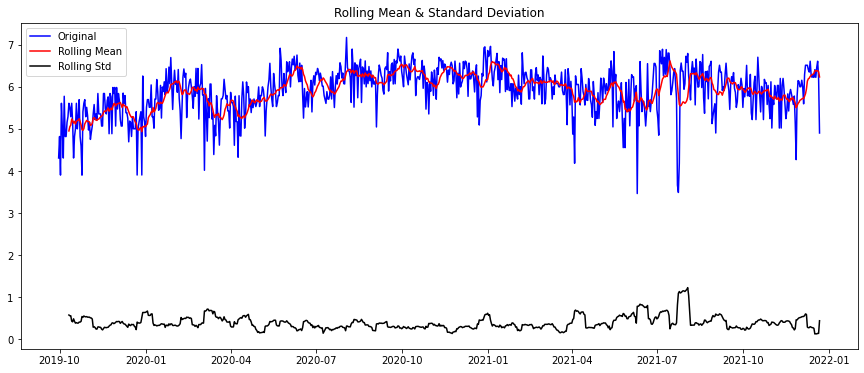

Results of Dickey-Fuller Test:
Test Statistic                  -3.083839
p-value                          0.027773
#Lags Used                      21.000000
Number of Observations Used    793.000000
Critical Value (1%)             -3.438623
Critical Value (5%)             -2.865192
Critical Value (10%)            -2.568714
dtype: float64


In [36]:
test_stationarity(data_log)

In [37]:
#It doesn't show a tendency.

In [38]:
#My timeSerie is Stationary

# Forcasting

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

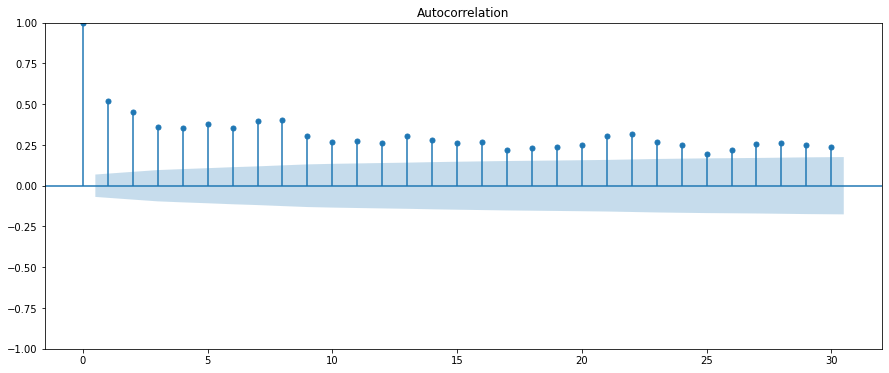

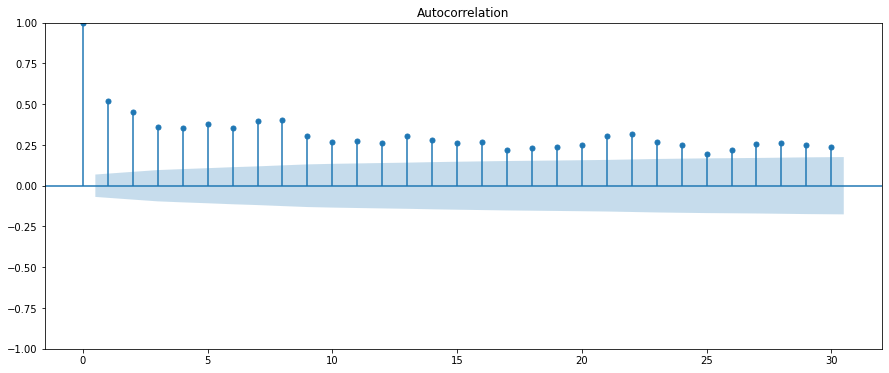

In [40]:
plot_acf(data_log)

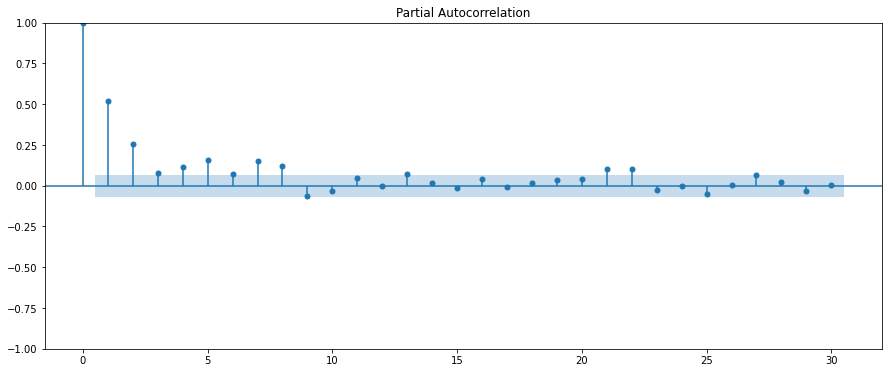

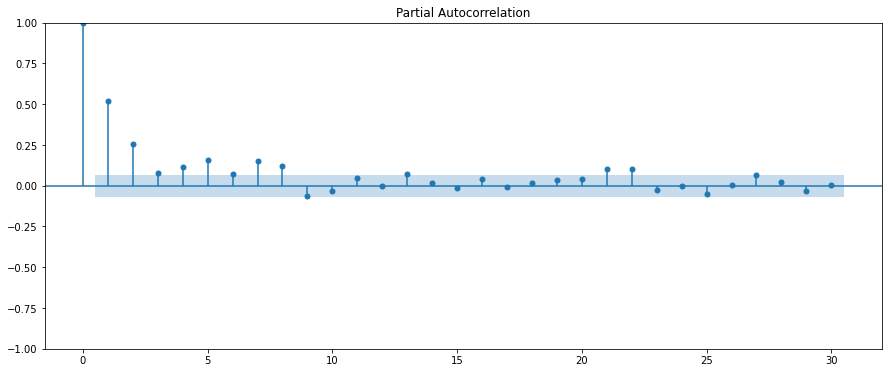

In [41]:
plot_pacf(data_log)

In [42]:
# SARIMAX Model

In [43]:
data_log

ds
2019-09-30    4.307438
2019-10-01    4.817698
2019-10-02    3.901973
2019-10-03    5.606500
2019-10-04    5.000585
                ...   
2021-12-18    6.222874
2021-12-19    6.459247
2021-12-20    6.605812
2021-12-21    6.222854
2021-12-22    4.901118
Name: y, Length: 815, dtype: float64

In [45]:
help(sm.tsa.statespace.SARIMAX)

Help on class SARIMAX in module statsmodels.tsa.statespace.sarimax:

class SARIMAX(statsmodels.tsa.statespace.mlemodel.MLEModel)
 |  SARIMAX(endog, exog=None, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0), trend=None, measurement_error=False, time_varying_regression=False, mle_regression=True, simple_differencing=False, enforce_stationarity=True, enforce_invertibility=True, hamilton_representation=False, concentrate_scale=False, trend_offset=1, use_exact_diffuse=False, dates=None, freq=None, missing='none', validate_specification=True, **kwargs)
 |  
 |  Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors
 |  model
 |  
 |  Parameters
 |  ----------
 |  endog : array_like
 |      The observed time-series process :math:`y`
 |  exog : array_like, optional
 |      Array of exogenous regressors, shaped nobs x k.
 |  order : iterable or iterable of iterables, optional
 |      The (p,d,q) order of the model for the number of AR parameters,
 |      differences, and MA p

param= pdq[7]
param_seasonal= seasonal_pdq[7]
mod = sm.tsa.statespace.SARIMAX(endog = data,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=True,
                                            freq='D')
results = mod.fit(disp=False)
print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))

In [48]:
p = q = range (2,4)
d = range(2,4)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 30) for x in list(itertools.product(p, d, q))]

In [ ]:
AIC_list = []
for param,param_seasonal_seasonal in zip(pdq,seasonal_pdq):
    try:
        mod = sm.tsa.statespace.SARIMAX(endog = data,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=True,
                                        enforce_invertibility=False,
                                        freq='D')

        results = mod.fit(disp=False)

        print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        AIC_list.append('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
    except Exception as e:
        print(e)
        continue

In [47]:
len(AIC_list)

68

In [ ]:
#aplicar el que me de menor AIC
mod = sm.tsa.statespace.SARIMAX(data,
                                order=(2, 2, 2),
                                seasonal_order=(2, 2, 2, 30),
                                enforce_stationarity=True,
                                enforce_invertibility=False)

results = mod.fit()

In [ ]:
print(results.summary().tables[1])

In [ ]:
results.plot_diagnostics(figsize=(16, 8))

In [ ]:
data.tail()

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_ci = pred.conf_int()

In [ ]:
ax = data['2019':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(20, 9))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()

plt.show()

In [ ]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = data['2021-10':].plot(label='observed', figsize=(18, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')

plt.legend()
plt.show()

select from model 